In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as mp
import sys
import os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), 'script'))
from data_utils import *

In [2]:
# source: https://github.com/navoshta/KITTI-Dataset/blob/master/kitti-dataset.ipynb
def draw_point_cloud(ax, points, axes=[0, 1, 2], point_size = 0.1, xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
    ]
    axes_str = ['X', 'Y', 'Z']
    ax.grid(False)
    
    ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:, 3], cmap='gray')
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

In [3]:
DATA_PATH = '/home/liver/data/kitti/RawData/2011_09_26/2011_09_26_drive_0005_sync/'
TRACKING_PATH = '/home/liver/data/kitti/Tracking/training/label_02/0000.txt'

points = read_point_cloud(os.path.join(DATA_PATH, 'velodyne_points/data/%010d.bin'%0))

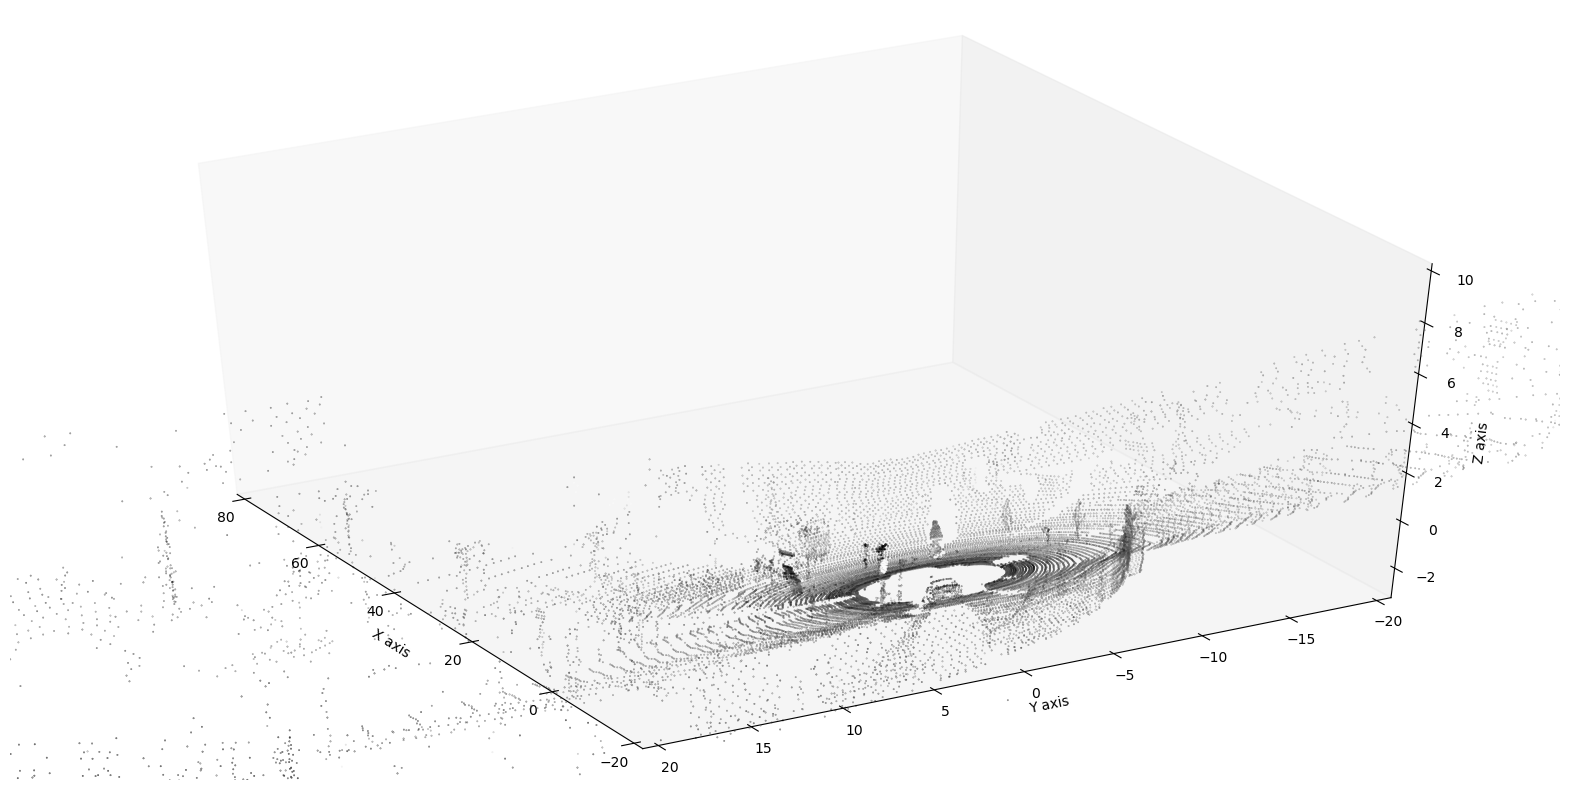

In [4]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,150)
draw_point_cloud(ax, points[::5])

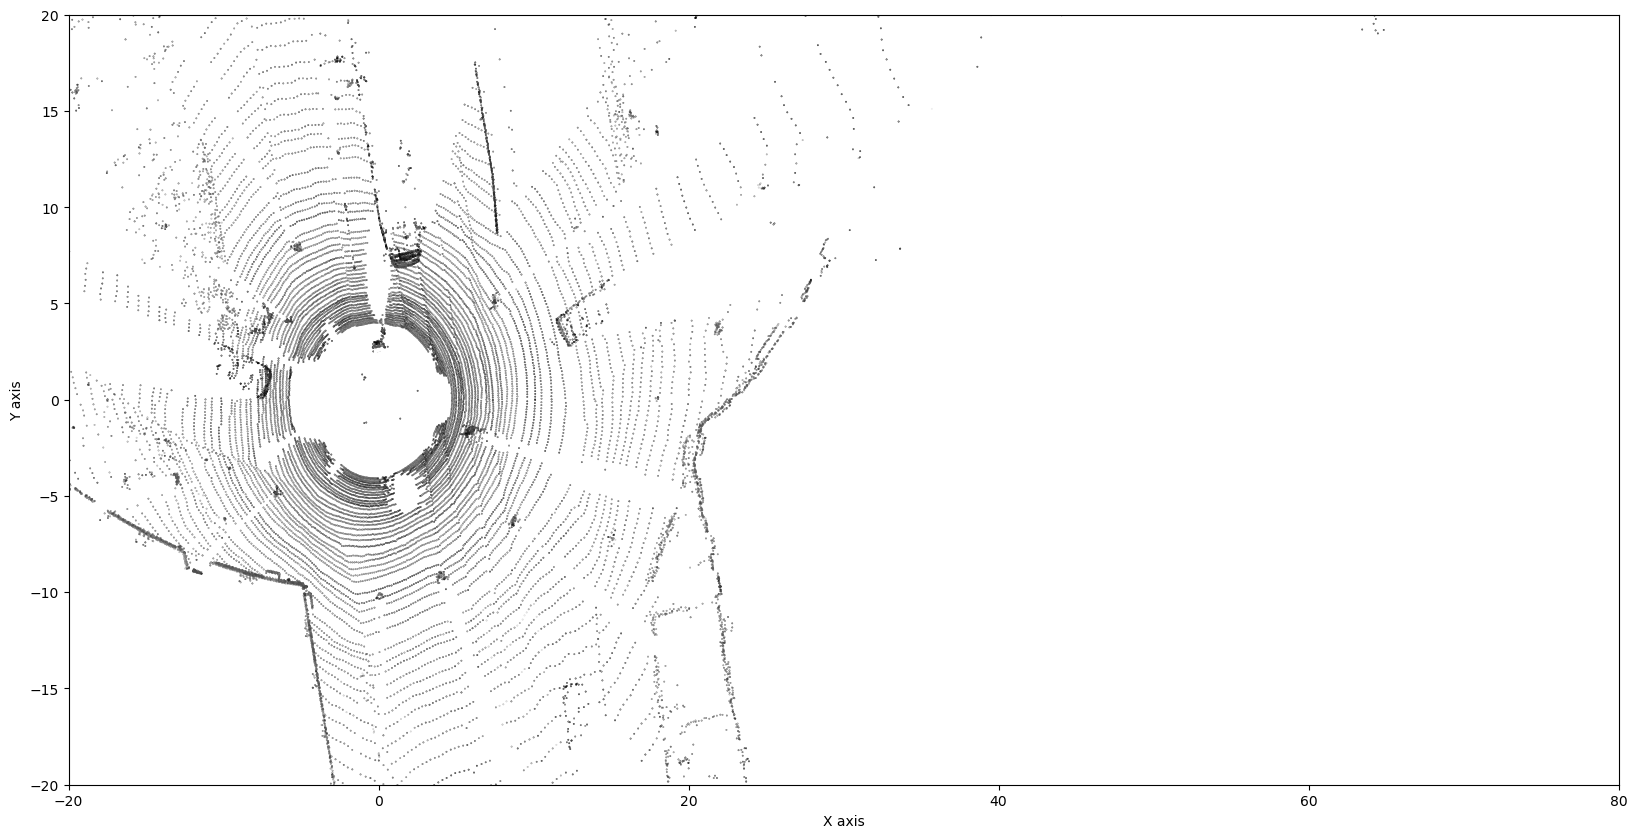

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points[::5], axes=[0,1])

In [6]:
df_tracking = read_tracking(TRACKING_PATH)
df_tracking.head()

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,height,width,length,pos_x,pos_y,pos_z,rot_y
2,0,0,Car,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458
7,1,0,Car,0,0,-1.796862,294.898777,156.024256,452.199718,284.621269,2.000000,1.823255,4.433886,-4.650955,1.766774,13.581085,-2.121565
8,1,1,Cyclist,0,0,-1.935205,745.017137,156.393157,938.839722,374.000000,1.739063,0.824591,1.785241,1.700640,1.640419,5.778596,-1.664456
12,2,0,Car,0,0,-1.800343,293.093560,150.470149,449.259225,277.104290,2.000000,1.823255,4.433886,-4.749625,1.675025,13.751675,-2.127642


In [7]:
def compute_3d_box_cam2(h, w, l, x, y, z, yaw):
    """
    Return : 3xn in cam2 coordinate
    """
    R = np.array([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]])
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2]
    corners_3d_cam2 = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
    #     corners_3d_cam2[0,:] += x
    #     corners_3d_cam2[1,:] += y
    #     corners_3d_cam2[2,:] += z
    corners_3d_cam2 += np.vstack([x, y, z])
    return corners_3d_cam2

In [8]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

In [9]:
corners_3d_cam2 = compute_3d_box_cam2(*df_tracking.loc[2,['height', 'width', 'length', 'pos_x', 'pos_y', 'pos_z', 'rot_y']])
corners_3d_cam2

array([[-6.48070602, -4.92129955, -2.62386198, -4.18326845, -6.48070602,
        -4.92129955, -2.62386198, -4.18326845],
       [ 1.858523  ,  1.858523  ,  1.858523  ,  1.858523  , -0.141477  ,
        -0.141477  , -0.141477  , -0.141477  ],
       [14.83425393, 15.77898154, 11.98673607, 11.04200846, 14.83425393,
        15.77898154, 11.98673607, 11.04200846]])

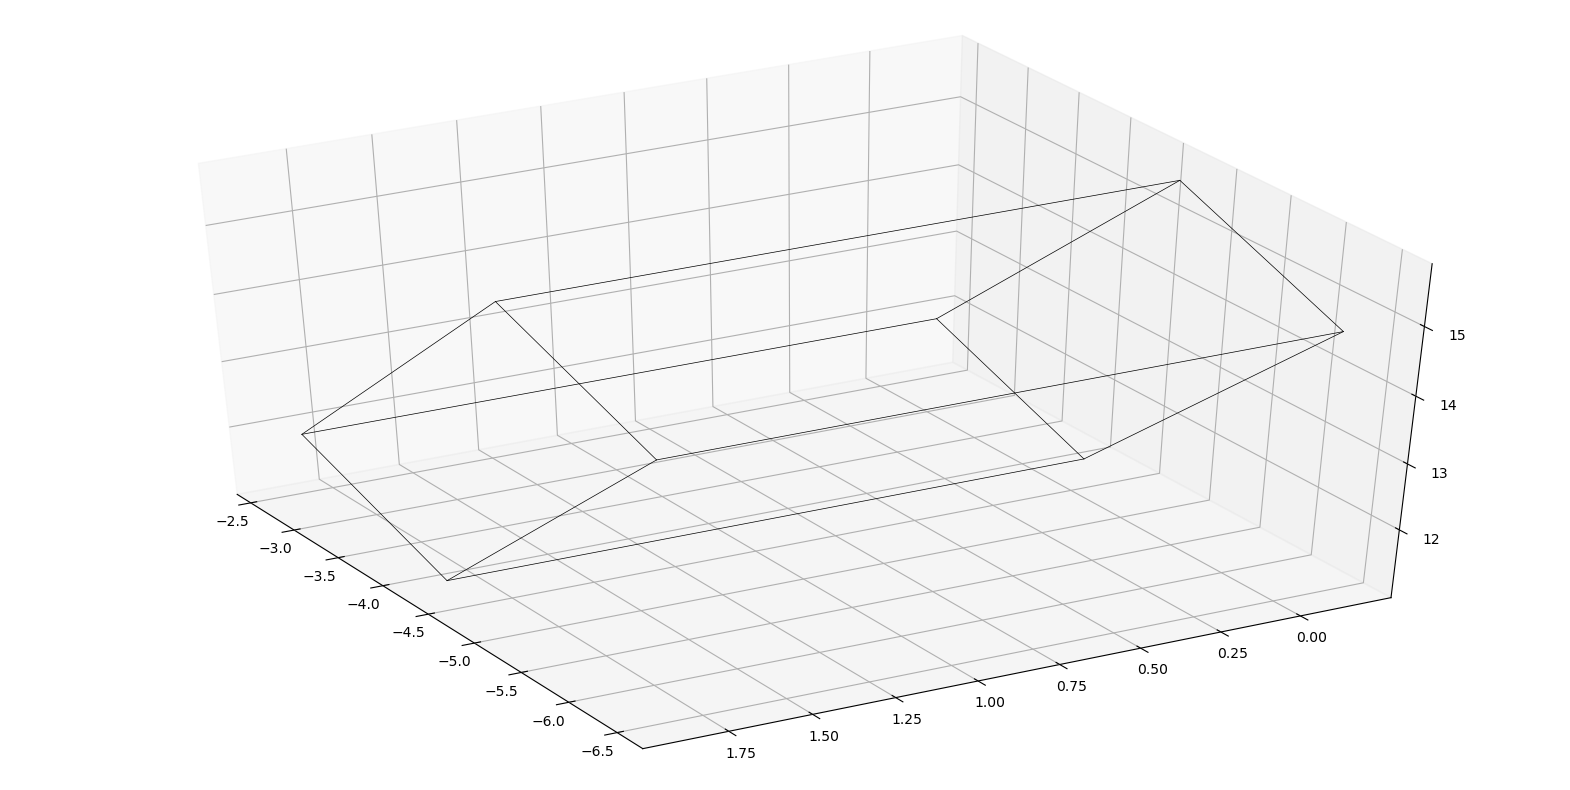

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,150)
draw_box(ax, corners_3d_cam2)

In [11]:
from kitti_util import *

In [12]:
calib = Calibration('/home/liver/data/kitti/RawData/2011_09_26/', from_video=True)

corners_3d_velo = calib.project_rect_to_velo(corners_3d_cam2.T).T
corners_3d_velo

array([[15.12424719, 16.06928938, 12.27779014, 11.33274795, 15.10334837,
        16.04839056, 12.25689133, 11.31184914],
       [ 6.49985556,  4.9406537 ,  2.64287284,  4.2020747 ,  6.47872485,
         4.91952299,  2.62174213,  4.18094399],
       [-1.70710774, -1.71370686, -1.7776097 , -1.77101058,  0.29267156,
         0.28607244,  0.2221696 ,  0.22876872]])

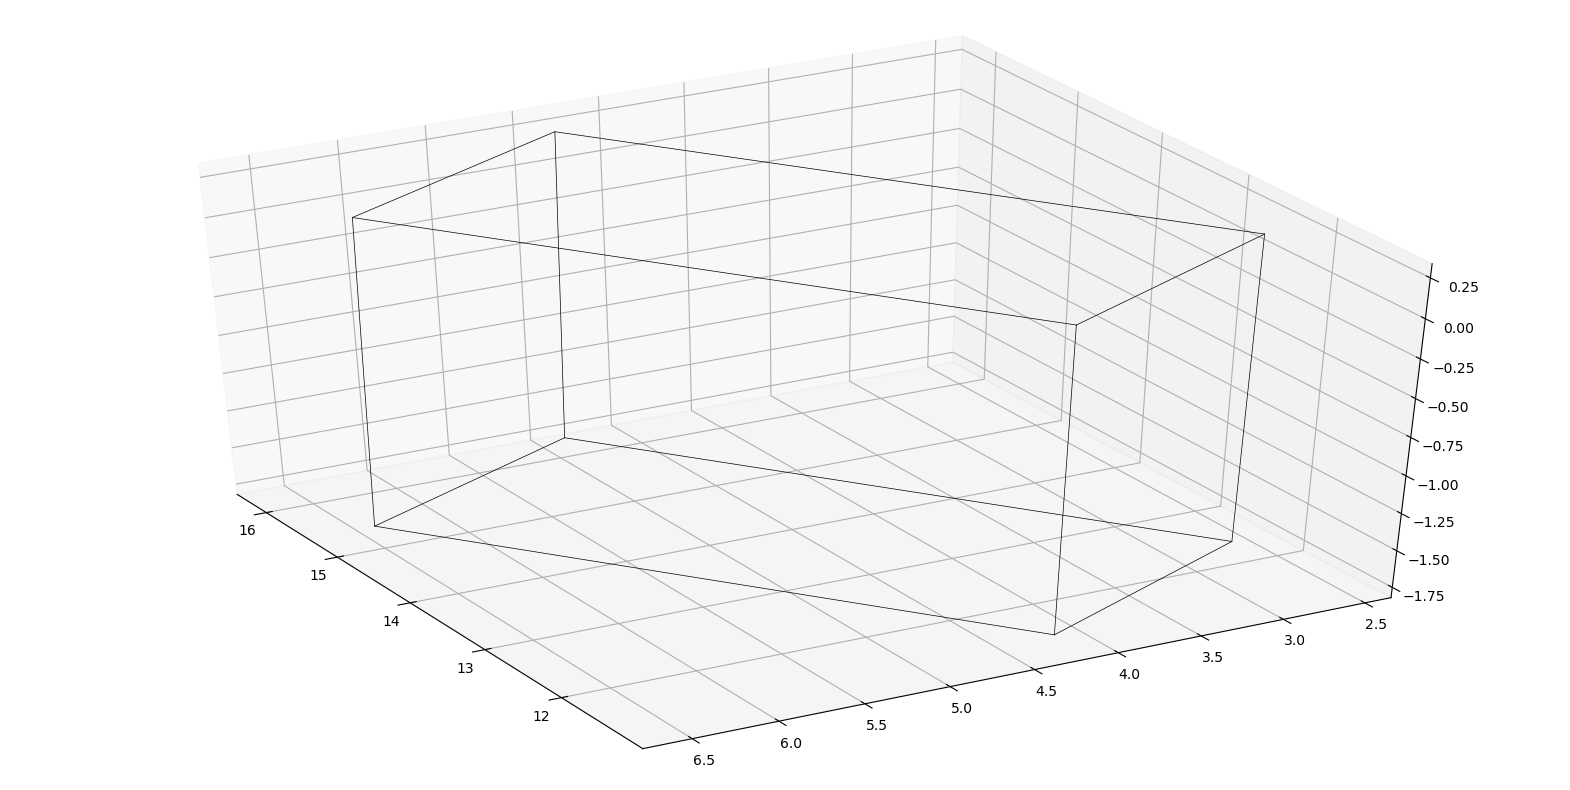

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,150)
draw_box(ax, corners_3d_velo)

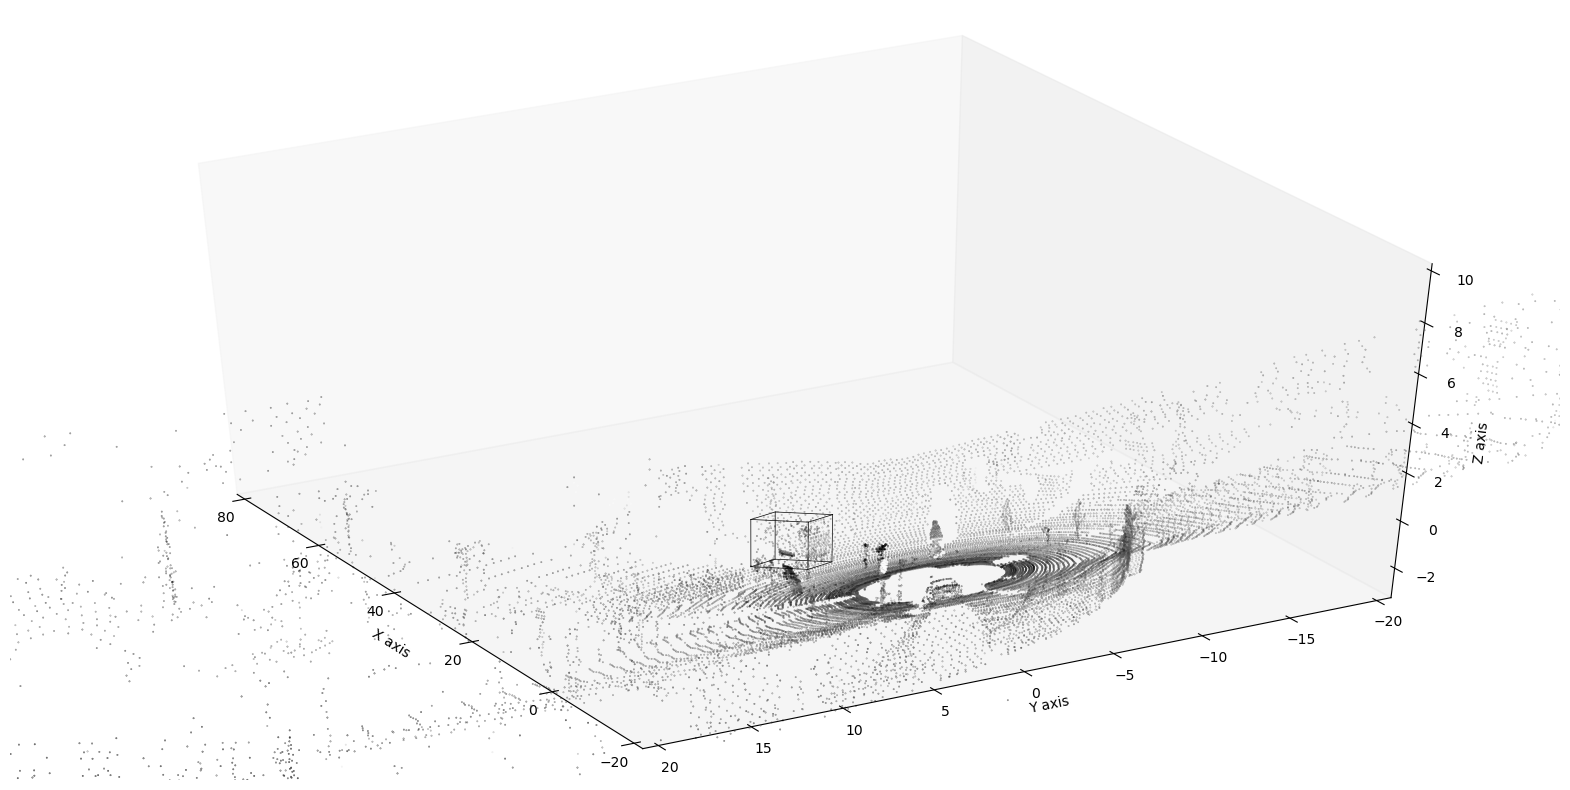

In [14]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,150)
draw_point_cloud(ax, points[::5])
draw_box(ax, corners_3d_velo)

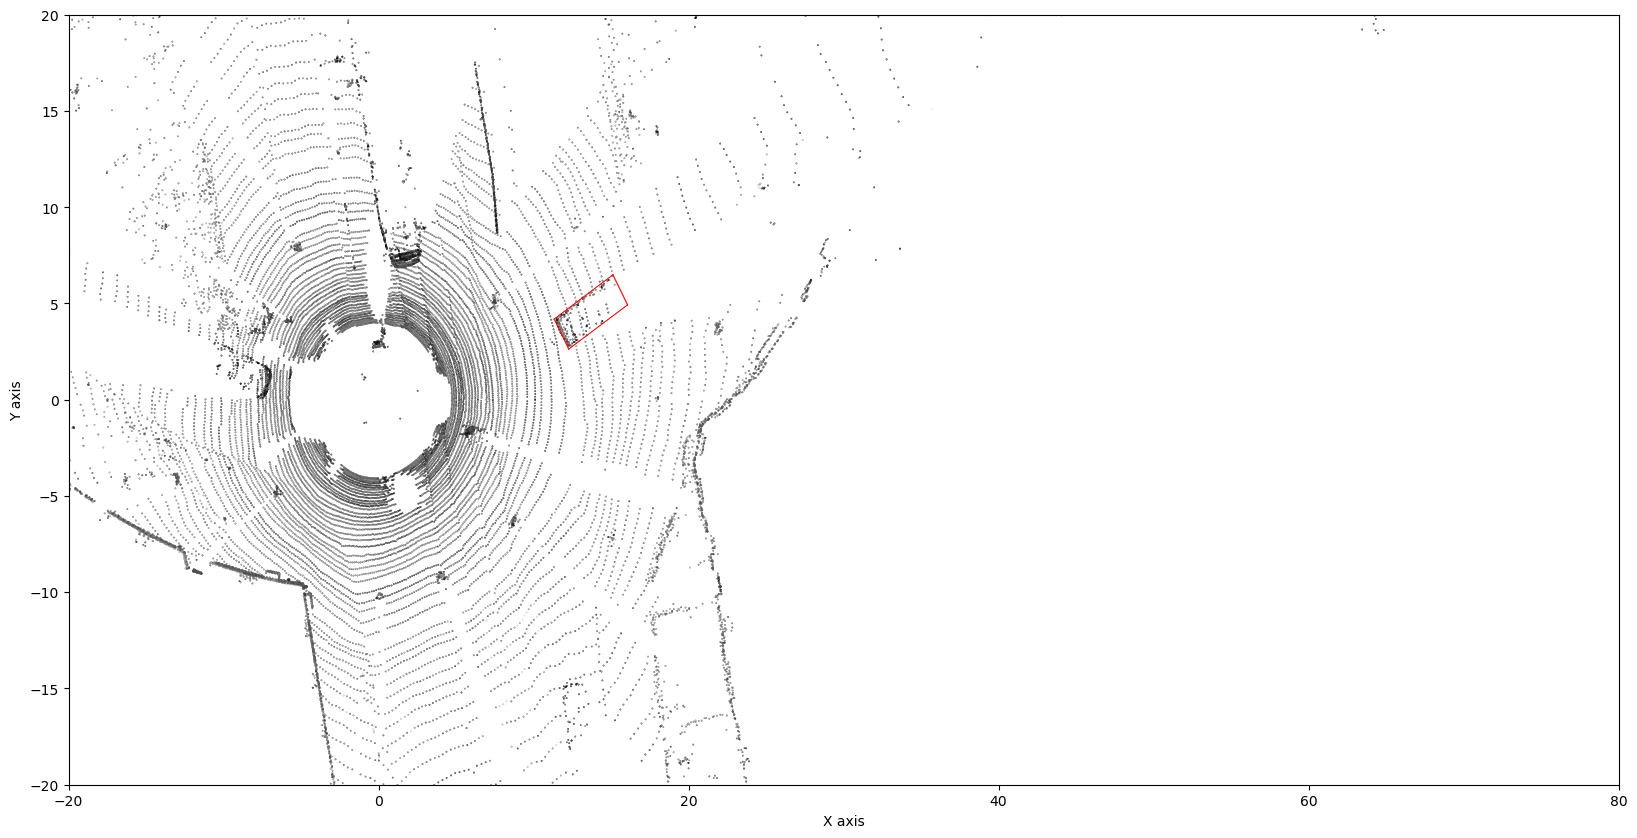

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
draw_point_cloud(ax, points[::5], axes=[0,1])
draw_box(ax, corners_3d_velo, axes=[0,1], color = 'r')